# Exercise 6.6

## 01 Import Libraries and Data set

In [3]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [4]:
# Configure API key 
quandl.ApiConfig.api_key = 'yupBUGuyc1fy6gfRceE8'

In [5]:
data = quandl.get('QDL/OPEC')

QuandlError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

**For the purpose of the task I will download it manually and import it personally**

In [7]:
# Path creation
path = r'/Users/Andreas/Desktop/'

# Import QDL/OPEC
df = pd.read_csv(os.path.join(path, 'QDL_OPEC.csv'))

In [9]:
df.head()

,date,value
0,2024-01-25,81.98
1,2023-12-04,79.63
2,2023-12-01,82.54
3,2023-11-30,85.00
4,2023-11-29,83.89


In [11]:
df.shape

(5435, 2)

In [12]:
df.columns

Index(['date', 'value'], dtype='object')

In [14]:
type(df)

pandas.core.frame.DataFrame

## Wrangling and Line Plot

In [18]:
# Create a new DataFrame with only the 'date' and 'value' columns
df2 = df[['date', 'value']].copy()  # Use .copy() to avoid Setting With Copy Warning

In [20]:
# Convert date column to datetime
df2['date'] = pd.to_datetime(df['date'])

# Extract year
df2['year'] = df2['date'].dt.year

# Group by year and calculate average
average_oil_price = df2.groupby('year')['value'].mean().reset_index()

# sort dates in correct order
df2.sort_values('date', inplace=True)

# Display results
print(average_oil_price)

    year       value
0   2003   28.123735
1   2004   36.009115
2   2005   50.707248
3   2006   61.080584
4   2007   69.076705
5   2008   94.452171
6   2009   61.058333
7   2010   77.445907
8   2011  107.464147
9   2012  109.452752
10  2013  105.873502
11  2014   96.133062
12  2015   49.504903
13  2016   40.759035
14  2017   52.429611
15  2018   69.781133
16  2019   64.037752
17  2020   41.466318
18  2021   69.891236
19  2022  100.079845
20  2023   82.947354
21  2024   79.323333


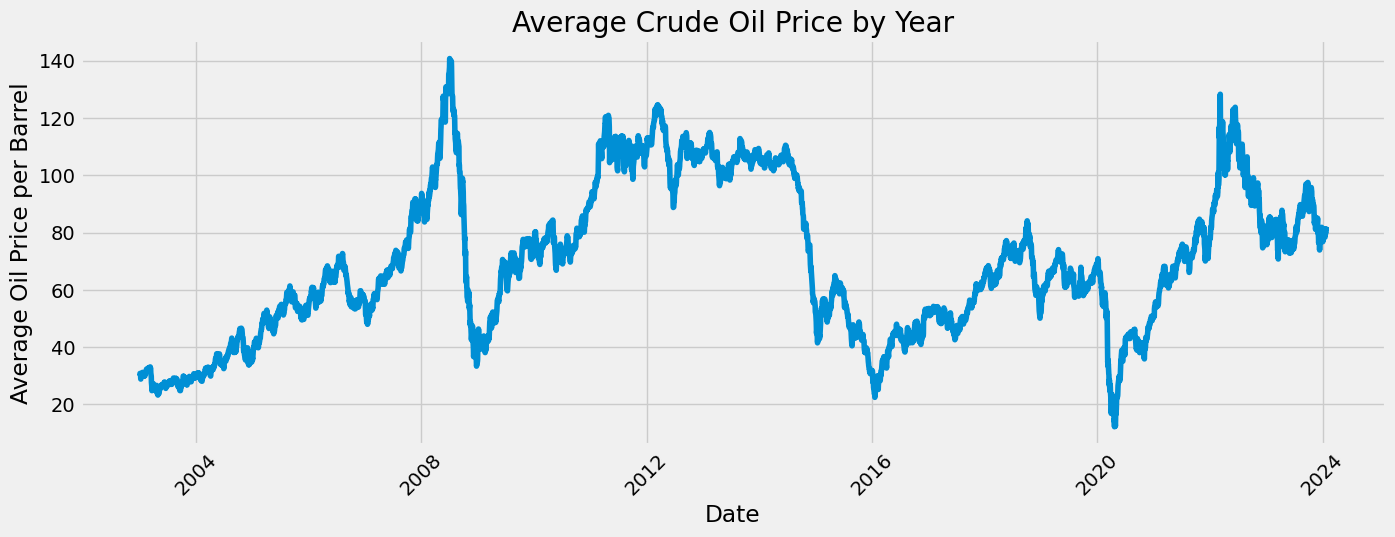

In [21]:
# Plot the data using matplotlib.

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df2['date'], df2['value'])
plt.xlabel('Date')
plt.ylabel('Average Oil Price per Barrel')
plt.title('Average Crude Oil Price by Year')
plt.xticks(rotation=45)
plt.show()

### Observations

(This is a stationary time series) From 2003 to 2009 there is a continous and steep increase (apart from a small dipp between 2006 to 2007) and then it drops rapidly. From 2011 to 2014 we see prices remaing very high between 90 to 125. In general the line chart is very volatile. There are definitely external factors that are affecting the price such as wars, not being able to find oil, legal issues on where to dig etc.

## 03 Time-Series Analysis: Decomposition

In [26]:
# Set the "date" column as the index

from datetime import datetime

df['datetime'] = pd.to_datetime(df['date']) # Create a datetime column from "date.""
df = df.set_index('datetime') # Set the datetime as the index of the dataframe.
df.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
df = df.asfreq('D')  # 'D' for daily frequency
df.isnull().sum()

value    2259
dtype: int64

In [28]:
df.dropna(inplace=True)

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df['value'], model='additive', period=365)

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

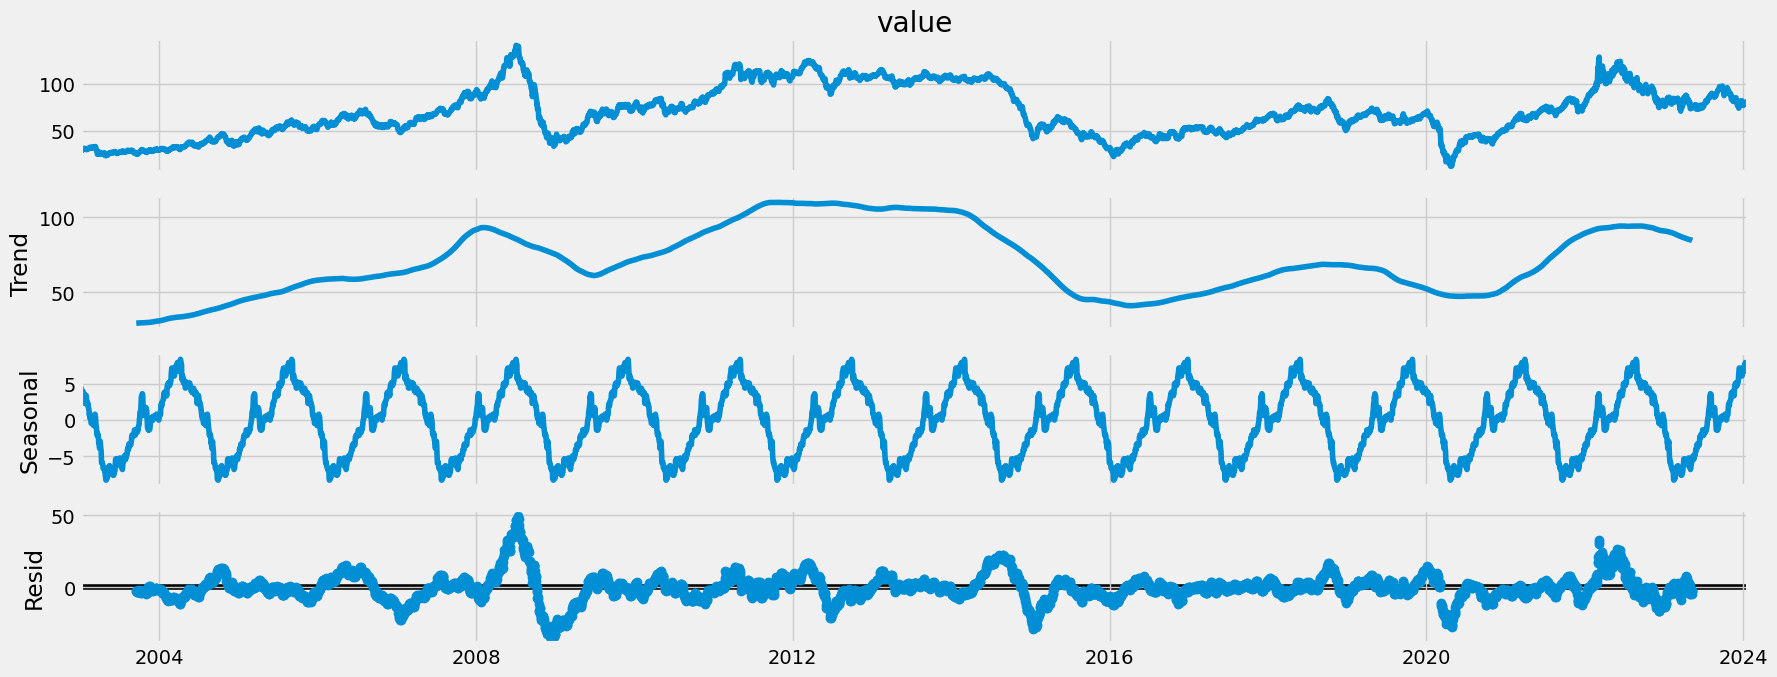

In [36]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observations

The level and trend are almost identical there is a little bit of noise however the lines are fairly similar. It is relatively smooth.

There is definitely a Seasonal trend occuring. Seasonality in crude oil prices is influenced by various factors, including seasonal demand fluctuations for heating oil in winter and gasoline in summer, as well as geopolitical events and economic conditions amongst other things that could explain why there is a repeating trend

The residual shows there is a some noise within the data especially between 2008 and 2009, regardless of that though the rest is fairly close to the 0 line. As stated previously we can see some noise in the level comppared to the trend however they have a very similar shape with the exception of 2008 to 2009 where in the level its more exagerated than in the trend.

## 04 Testing for stationarity

In [45]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.900015
p-value                           0.045346
Number of Lags Used              31.000000
Number of Observations Used    5403.000000
Critical Value (1%)              -3.431561
Critical Value (5%)              -2.862075
Critical Value (10%)             -2.567055
dtype: float64


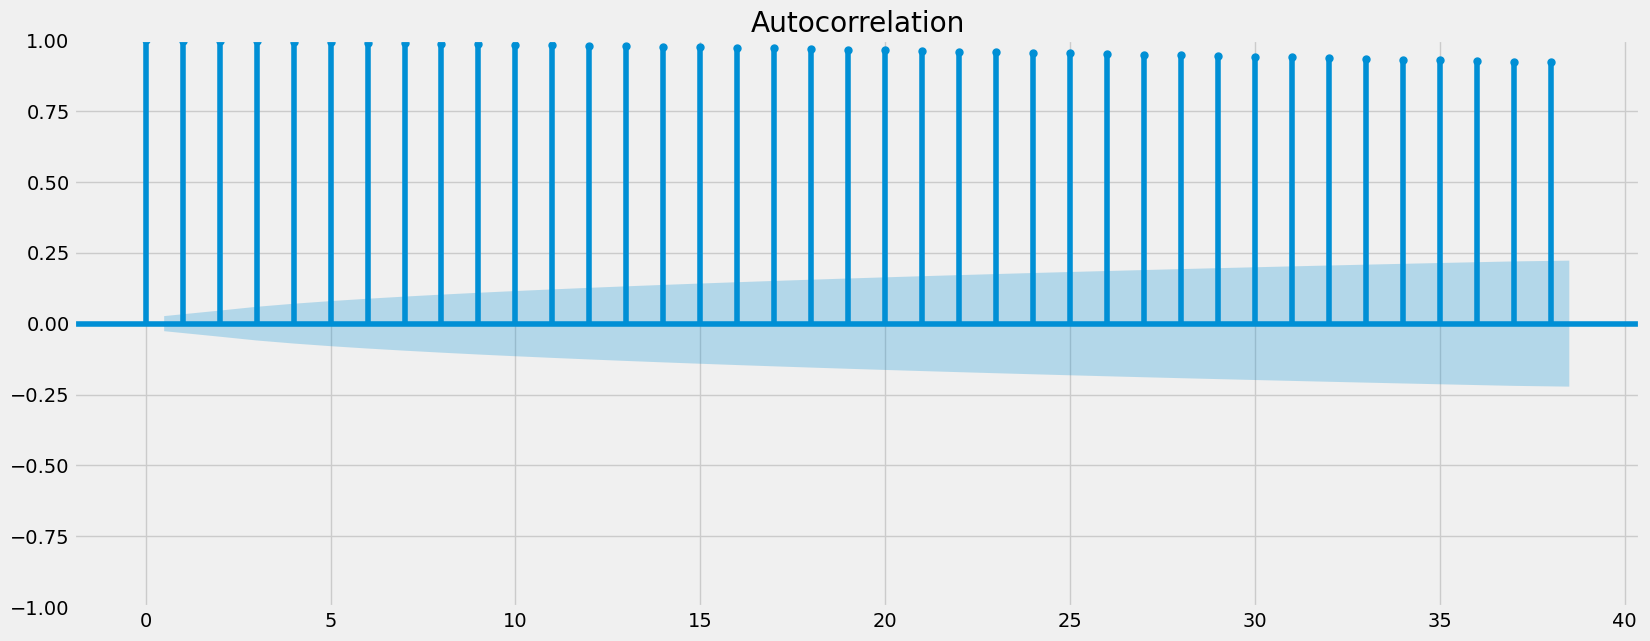

In [48]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df)
plt.show()

### Observations

The Lags are heavily correlated with each other all being at 1.0 this shows my data is non-stationary, also our p-value is 0.045 which is less than the siginificance level of 0.05 so we can reject the null-hypothesis that the unit root is present indicating the data is stationary